In [216]:
#Importing Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [217]:
def fillMissTime():
    df = pd.read_csv("./data/Parts_EQP_Output_ByMonth_20210407_van.csv")
    df['MFG_MONTH'] = pd.to_datetime(df['MFG_MONTH'].values, format='%Y%m').astype('period[M]')
    df=df[df['PART_NO']=='85-ECT0010'] 
    df =df.groupby(['MFG_MONTH']).sum()
    

    df = df.sort_values(by=['MFG_MONTH'], ascending=[True])
    df.reindex(pd.period_range(df.index[0],df.index[-1],freq='M'))

    df = df.reset_index()
    df.drop(columns=['PM','TS','ENG','NST'],inplace=True)
    return df[df['MFG_MONTH']<='202012']  ,df[df['MFG_MONTH']>'202012']     


In [223]:

#Importing the Training Dataset
# train = pd.read_csv('./LSTMDATA/Google_Stock_Price_Train.csv') # 1258
train ,test = fillMissTime()
print(train.shape,test.shape)
training_set = train.iloc[:, 1:2].values

#Featuring Scaling
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0,1))
scaled_training_data = sc.fit_transform(training_set)

#Creating Data Structure with 60 Time Stamps and 1 output
x_train = []
y_train = []
look_back = 1
for i in range(look_back,train.shape[0]):
    x_train.append(scaled_training_data[i-look_back:i, 0])
    y_train.append(scaled_training_data[i, 0])
x_train, y_train = np.array(x_train), np.array(y_train)

#Reshaping
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
print(len(x_train))




(72, 2) (3, 2)
71


In [224]:
train.shape[0]
len(y_train)

71

In [225]:
#Building the RNN
#Importing the tensorflow libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout

#Initilizing RNN
LSTMmodel = Sequential()

#Adding first LSTM Layer and Dropout Regularization
LSTMmodel.add(LSTM(units = 50, return_sequences = True, input_shape = (x_train.shape[1], 1)))
LSTMmodel.add(Dropout(rate = 0.2))

#Adding Second LSTM Layer and Dropout Regularization
LSTMmodel.add(LSTM(units = 50, return_sequences = True))
LSTMmodel.add(Dropout(rate = 0.2))

#Adding Third LSTM Layer and Dropout Regularization
LSTMmodel.add(LSTM(units = 50, return_sequences = True))
LSTMmodel.add(Dropout(rate = 0.2))

#Adding fourth LSTM Layer and Dropout Regularization
LSTMmodel.add(LSTM(units = 50))
LSTMmodel.add(Dropout(rate = 0.2))

#Adding the output Layer
LSTMmodel.add(Dense(units = 1))

#Compiling the RNN
LSTMmodel.compile(optimizer = 'adam', loss = 'mean_squared_error' )

#Fitting the RNN to the Training Set
LSTMmodel.fit(x_train, y_train, epochs = 100, batch_size = 16)

Train on 71 samples
Epoch 1/100
71/71 [==============================] - 10s 144ms/sample - loss: 0.4860
Epoch 2/100
71/71 [==============================] - 0s 380us/sample - loss: 0.4593
Epoch 3/100
71/71 [==============================] - 0s 479us/sample - loss: 0.4312
Epoch 4/100
71/71 [==============================] - 0s 521us/sample - loss: 0.3971
Epoch 5/100
71/71 [==============================] - 0s 422us/sample - loss: 0.3546
Epoch 6/100
71/71 [==============================] - 0s 436us/sample - loss: 0.3030
Epoch 7/100
71/71 [==============================] - 0s 451us/sample - loss: 0.2407
Epoch 8/100
71/71 [==============================] - 0s 563us/sample - loss: 0.1564
Epoch 9/100
71/71 [==============================] - 0s 521us/sample - loss: 0.0871
Epoch 10/100
71/71 [==============================] - 0s 408us/sample - loss: 0.0453
Epoch 11/100
71/71 [==============================] - 0s 493us/sample - loss: 0.0655
Epoch 12/100
71/71 [==============================] -

In [211]:
# _test = pd.read_csv('./LSTMDATA/Google_Stock_Price_Test.csv')
# _real_stock_price = _test.iloc[:, 1:2].values
# _real_stock_price

In [228]:
#Making the predictions and visulization

#Getting the real stock price of google
# test = pd.read_csv('./LSTMDATA/Google_Stock_Price_Test.csv')
# real_stock_price = test.iloc[:, 1:2].values
real_stock_price = test['QTY'].iloc[:].values

# Getting the predicted stock price of 2017
dataset_total = pd.concat((train['QTY'], test['QTY']), axis = 0)
inputs = dataset_total[len(dataset_total) - len(test) - look_back:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
X_test = []
for i in range(look_back, test.shape[0]):
    X_test.append(inputs[i-look_back:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predicted_stock_price = LSTMmodel.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)


In [229]:
predicted_stock_price

array([[219.94766],
       [227.24068]], dtype=float32)

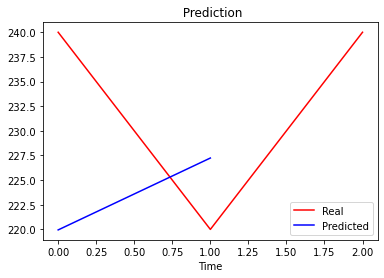

In [230]:
# Visualising the results
plt.plot(real_stock_price, color = 'red', label = 'Real')
plt.plot(predicted_stock_price, color = 'blue', label = 'Predicted')
plt.title(' Prediction')
plt.xlabel('Time')
# plt.ylabel('Google Stock Price')
plt.legend()
plt.show()

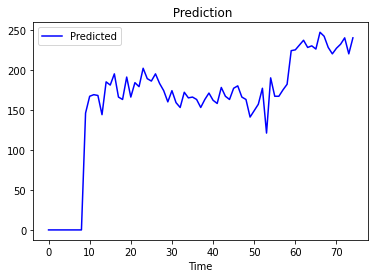

In [232]:
 
plt.plot(dataset_total, color = 'blue', label = 'Predicted')
plt.title(' Prediction')
plt.xlabel('Time')
# plt.ylabel('Google Stock Price')
plt.legend()
plt.show()

Train on 1198 samples
Epoch 1/100
1198/1198 [==============================] - 14s 12ms/sample - loss: 0.0390
Epoch 2/100
1198/1198 [==============================] - 3s 3ms/sample - loss: 0.0070
Epoch 3/100
1198/1198 [==============================] - 3s 3ms/sample - loss: 0.0052
Epoch 4/100
1198/1198 [==============================] - 4s 3ms/sample - loss: 0.0050
Epoch 5/100
1198/1198 [==============================] - 3s 3ms/sample - loss: 0.0053
Epoch 6/100
1198/1198 [==============================] - 4s 3ms/sample - loss: 0.0047
Epoch 7/100
1198/1198 [==============================] - 3s 3ms/sample - loss: 0.0044
Epoch 8/100
1198/1198 [==============================] - 3s 3ms/sample - loss: 0.0047
Epoch 9/100
1198/1198 [==============================] - 3s 3ms/sample - loss: 0.0044
Epoch 10/100
1198/1198 [==============================] - 4s 3ms/sample - loss: 0.0041
Epoch 11/100
1198/1198 [==============================] - 3s 3ms/sample - loss: 0.0049
Epoch 12/100
1198/1198 [====

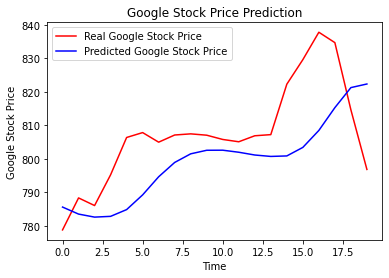

In [176]:


#Importing Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#Importing the Training Dataset
train = pd.read_csv('./LSTMDATA/Google_Stock_Price_Train.csv')
training_set = train.iloc[:, 1:2].values

#Featuring Scaling
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0,1))
scaled_training_data = sc.fit_transform(training_set)

#Creating Data Structure with 60 Time Stamps and 1 output
x_train = []
y_train = []
for i in range(60,1258):
    x_train.append(scaled_training_data[i-60:i, 0])
    y_train.append(scaled_training_data[i, 0])
x_train, y_train = np.array(x_train), np.array(y_train)

#Reshaping
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

#Building the RNN
#Importing the tensorflow libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout

#Initilizing RNN
model = Sequential()

#Adding first LSTM Layer and Dropout Regularization
model.add(LSTM(units = 50, return_sequences = True, input_shape = (x_train.shape[1], 1)))
model.add(Dropout(rate = 0.2))

#Adding Second LSTM Layer and Dropout Regularization
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(rate = 0.2))

#Adding Third LSTM Layer and Dropout Regularization
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(rate = 0.2))

#Adding fourth LSTM Layer and Dropout Regularization
model.add(LSTM(units = 50))
model.add(Dropout(rate = 0.2))

#Adding the output Layer
model.add(Dense(units = 1))

#Compiling the RNN
model.compile(optimizer = 'adam', loss = 'mean_squared_error' )

#Fitting the RNN to the Training Set
model.fit(x_train, y_train, epochs = 100, batch_size = 32)

#Making the predictions and visulization

#Getting the real stock price of google
test = pd.read_csv('./LSTMDATA/Google_Stock_Price_Test.csv')
real_stock_price = test.iloc[:, 1:2].values

# Getting the predicted stock price of 2017
dataset_total = pd.concat((train['Open'], test['Open']), axis = 0)
inputs = dataset_total[len(dataset_total) - len(test) - 60:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
X_test = []
for i in range(60, 80):
    X_test.append(inputs[i-60:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predicted_stock_price = model.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)




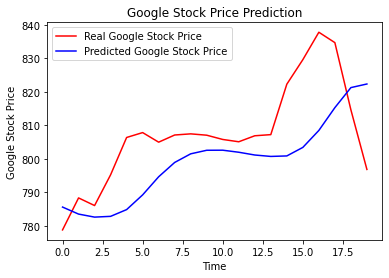

In [178]:
# Visualising the results
plt.plot(real_stock_price, color = 'red', label = 'Real Google Stock Price')
plt.plot(predicted_stock_price, color = 'blue', label = 'Predicted Google Stock Price')
plt.title('Google Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Google Stock Price')
plt.legend()
plt.show()


In [183]:
dataset_total

0     325.25
1     331.27
2     329.83
3     328.34
4     322.04
       ...  
15    829.62
16    837.81
17    834.71
18    814.66
19    796.86
Name: Open, Length: 1278, dtype: float64